In [1]:
from pyspark.sql import SparkSession
from os.path import abspath

warehouse_location = abspath('spark-warehouse')

spark = SparkSession.builder    \
    .config('spark.driver.memory', '32g')   \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.sql.catalogImplementation","hive") \
    .enableHiveSupport()   \
    .getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/14 01:39:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
orders_sdf = spark.read.csv('data/instacart_market/orders.csv', header=True, inferSchema=True)
order_products_train_sdf = spark.read.csv('data/instacart_market/order_products_train.csv', header=True, inferSchema=True)
order_products_prior_sdf = spark.read.csv('data/instacart_market/order_products_prior.csv', header=True, inferSchema=True)
products_sdf = spark.read.csv('data/instacart_market/products.csv', header=True, inferSchema=True)
aisles_sdf = spark.read.csv('data/instacart_market/aisles.csv', header=True, inferSchema=True)
departments_sdf = spark.read.csv('data/instacart_market/departments.csv', header=True, inferSchema=True)

In [3]:
sdf_dict = {
    'orders': orders_sdf,
    'order_products_train': order_products_train_sdf,
    'order_products_prior': order_products_prior_sdf,
    'products': products_sdf,
    'aisles': aisles_sdf,
    'departments': departments_sdf,
}
for sdf_name, sdf in sdf_dict.items():
    print(f'{sdf_name} schema')
    print(sdf.printSchema())

orders schema
root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)

None
order_products_train schema
root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)

None
order_products_prior schema
root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)

None
products schema
root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)

None
aisles schema
root
 |-- aisle_id: 

In [4]:
for name, sdf in sdf_dict.items():
    sdf.createOrReplaceTempView(name)

In [5]:
spark.catalog.listTables()

23/06/14 01:40:17 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/06/14 01:40:17 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/06/14 01:40:28 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/06/14 01:40:28 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.17.0.2
23/06/14 01:40:29 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


[Table(name='order_all_products', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='priors_trains', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='aisles', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='departments', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='order_products_prior', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='order_products_train', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='orders', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='products', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [ ]:
spark.sql('''
drop table if exists priors_trains
''').show(truncate=False)

In [ ]:
spark.sql('''
create table priors_trains
as
select 'train' as class, t.* from order_products_train t
union all
select 'prior' as class, p.* from order_products_prior p 
''').show(truncate=False)

In [ ]:
query = '''
drop table if exists order_all_products
'''
spark.sql(query).show()

In [ ]:
query = '''
create table order_all_products
as
select p.order_id, p.product_id, p.add_to_cart_order, p.reordered,
    o.user_id, o.eval_set, o.order_number, o.order_dow, o.order_hour_of_day, o.days_since_prior_order
from priors_trains p, orders o
where p.order_id = o.order_id
'''
spark.sql(query).show()

In [6]:
spark.sql('''
select * from order_all_products where user_id = 1 order by order_number
''').show(truncate=False)

23/06/14 01:40:47 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|2539329 |196       |1                |0        |1      |prior   |1           |2        |8                |null                  |
|2539329 |14084     |2                |0        |1      |prior   |1           |2        |8                |null                  |
|2539329 |12427     |3                |0        |1      |prior   |1           |2        |8                |null                  |
|2539329 |26088     |4                |0        |1      |prior   |1           |2        |8                |null                  |
|2539329 |26405     |5                |0        |1      |prior   |1           |2   

In [7]:
query = '''
select user_id, user_total_cnt, product_distinct_cnt, order_distinct_cnt
    , user_total_cnt / order_distinct_cnt as user_avg_product_cnt
    , user_total_cnt / product_distinct_cnt as user_avg_unique_product_cnt
    , product_distinct_cnt / user_total_cnt as user_unique_product_ratio
from (
    select user_id
        , count(*) as user_total_cnt
        , count(distinct product_id) product_distinct_cnt
        , count(distinct order_id) order_distinct_cnt
    from order_all_products o
    group by user_id
)
'''
spark.sql(query).show(truncate=False)

23/06/14 01:40:54 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/06/14 01:40:54 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/06/14 01:40:54 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist


+-------+--------------+--------------------+------------------+--------------------+---------------------------+-------------------------+
|user_id|user_total_cnt|product_distinct_cnt|order_distinct_cnt|user_avg_product_cnt|user_avg_unique_product_cnt|user_unique_product_ratio|
+-------+--------------+--------------------+------------------+--------------------+---------------------------+-------------------------+
|28024  |47            |38                  |5                 |9.4                 |1.236842105263158          |0.8085106382978723       |
|48254  |540           |149                 |40                |13.5                |3.6241610738255035         |0.2759259259259259       |
|196615 |398           |93                  |31                |12.838709677419354  |4.279569892473118          |0.23366834170854273      |
|166150 |338           |43                  |54                |6.2592592592592595  |7.8604651162790695         |0.12721893491124261      |
|172616 |367        

In [8]:
query = '''
with order_user_group as (
    select user_id, user_total_cnt, product_distinct_cnt, order_distinct_cnt
        , user_total_cnt / order_distinct_cnt as user_avg_product_cnt
        , user_total_cnt / product_distinct_cnt as user_avg_unique_product_cnt
        , product_distinct_cnt / user_total_cnt as user_unique_product_ratio
    from (
        select user_id
            , count(*) as user_total_cnt
            , count(distinct product_id) product_distinct_cnt
            , count(distinct order_id) order_distinct_cnt
        from order_all_products o
        group by user_id
    )
)
select avg(user_avg_product_cnt), min(user_avg_product_cnt), max(user_avg_product_cnt)
from order_user_group
'''
spark.sql(query).show(truncate=False)

+-------------------------+-------------------------+-------------------------+
|avg(user_avg_product_cnt)|min(user_avg_product_cnt)|max(user_avg_product_cnt)|
+-------------------------+-------------------------+-------------------------+
|9.984526700309315        |1.0                      |60.5                     |
+-------------------------+-------------------------+-------------------------+



+----+-------+
|bin |bin_cnt|
+----+-------+
|0.0 |39161  |
|5.0 |78697  |
|10.0|52853  |
|15.0|22584  |
|20.0|8477   |
|25.0|2973   |
|30.0|960    |
|35.0|329    |
|40.0|109    |
|45.0|42     |
|50.0|15     |
|55.0|7      |
|60.0|2      |
+----+-------+



<Axes: xlabel='bin'>

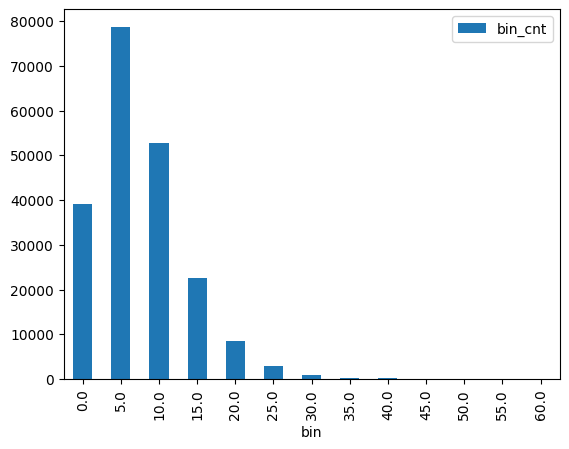

In [13]:
query = '''
with order_user_group as (
    select user_id, user_total_cnt, product_distinct_cnt, order_distinct_cnt
        , user_total_cnt / order_distinct_cnt as user_avg_product_cnt
        , user_total_cnt / product_distinct_cnt as user_avg_unique_product_cnt
        , product_distinct_cnt / user_total_cnt as user_unique_product_ratio
    from (
        select user_id
            , count(*) as user_total_cnt
            , count(distinct product_id) product_distinct_cnt
            , count(distinct order_id) order_distinct_cnt
        from order_all_products o
        group by user_id
    )
)
select floor(user_avg_product_cnt / 5.0) * 5.0 as bin, count(*) bin_cnt
from order_user_group
group by floor(user_avg_product_cnt / 5.0) * 5.0
order by 1
'''
sdf = spark.sql(query)
sdf.show(truncate=False)
pdf = sdf.toPandas()
pdf.plot.bar(x='bin', y='bin_cnt')

In [14]:
query = '''
select user_id, count(*)
, sum(reordered) user_reordered_cnt
, sum(case when reordered = 0 then 1 else 0 end) user_not_reordered_cnt
, avg(reordered) user_reordered_avg
from order_all_products
group by user_id
'''
spark.sql(query).show()

+-------+--------+------------------+----------------------+-------------------+
|user_id|count(1)|user_reordered_cnt|user_not_reordered_cnt| user_reordered_avg|
+-------+--------+------------------+----------------------+-------------------+
| 146988|     592|               413|                   179| 0.6976351351351351|
| 103747|     413|               340|                    73| 0.8232445520581114|
|  13623|     620|               398|                   222| 0.6419354838709678|
|  26708|     678|               533|                   145| 0.7861356932153393|
| 194974|     183|                91|                    92| 0.4972677595628415|
|  16861|      46|                17|                    29| 0.3695652173913043|
| 181700|     291|               178|                   113| 0.6116838487972509|
|  15957|     260|               187|                    73| 0.7192307692307692|
|  31035|     270|               168|                   102| 0.6222222222222222|
| 158257|     592|          

In [20]:
query = '''
select * from order_all_products
-- group by user_id
'''
spark.sql(query).show()

+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|       3|     33754|                1|        1| 205970|   prior|          16|        5|               17|                  12.0|
|       3|     24838|                2|        1| 205970|   prior|          16|        5|               17|                  12.0|
|       3|     17704|                3|        1| 205970|   prior|          16|        5|               17|                  12.0|
|       3|     21903|                4|        1| 205970|   prior|          16|        5|               17|                  12.0|
|       3|     17668|                5|        1| 205970|   prior|          16|    

In [19]:
query = '''
with 
order_user_group as 
(
    select user_id, count(*) user_total_cnt
    , sum(reordered) user_reordered_cnt    
    , avg(reordered) user_reordered_avg
    from order_all_products
    group by user_id
)
select min(user_reordered_cnt), max(user_reordered_cnt), avg(user_reordered_cnt)
from order_user_group
'''
spark.sql(query).show()

+-----------------------+-----------------------+-----------------------+
|min(user_reordered_cnt)|max(user_reordered_cnt)|avg(user_reordered_cnt)|
+-----------------------+-----------------------+-----------------------+
|                      0|                   3275|       96.7724978056244|
+-----------------------+-----------------------+-----------------------+



+---+-------+
|bin|bin_cnt|
+---+-------+
|0.0|8734   |
|0.1|18431  |
|0.2|28930  |
|0.3|31798  |
|0.4|33279  |
|0.5|33244  |
|0.6|26028  |
|0.7|17917  |
|0.8|7137   |
|0.9|711    |
+---+-------+



<Axes: xlabel='bin'>

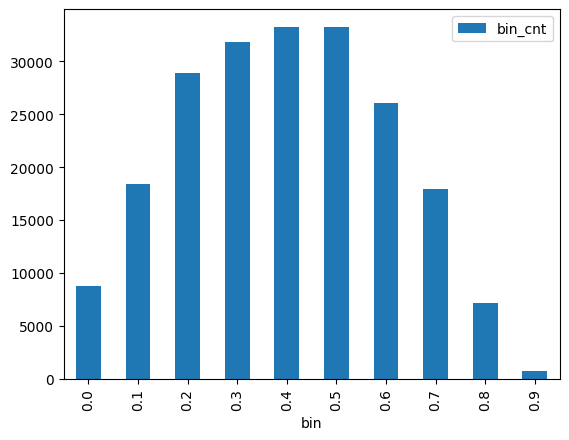

In [17]:
query = '''
with
order_user_group as
(
    select user_id, count(*) as user_total_cnt
    , sum(reordered) user_reordered_cnt
    , avg(reordered) user_reordered_avg
    from order_all_products
    group by user_id
)
select floor(user_reordered_avg / 0.1) * 0.1 as bin, count(*) bin_cnt
from order_user_group
group by floor(user_reordered_avg / 0.1) * 0.1
order by 1
'''
sdf = spark.sql(query)
sdf.show(truncate=False)
pdf = sdf.toPandas()
pdf.plot.bar(x='bin', y='bin_cnt')

In [21]:
query = '''
select user_id, avg(days_since_prior_order) user_avg_prior_days
, max(days_since_prior_order) user_max_prior_days
, min(days_since_prior_order) user_min_prior_days
from  order_all_products
group by user_id
order by user_id
limit 30
'''
spark.sql(query).show(truncate=False)

+-------+-------------------+-------------------+-------------------+
|user_id|user_avg_prior_days|user_max_prior_days|user_min_prior_days|
+-------+-------------------+-------------------+-------------------+
|1      |19.2               |30.0               |0.0                |
|2      |18.009389671361504 |30.0               |3.0                |
|3      |11.487179487179487 |21.0               |7.0                |
|4      |15.357142857142858 |21.0               |0.0                |
|5      |12.314285714285715 |19.0               |6.0                |
|6      |7.8                |12.0               |6.0                |
|7      |13.211822660098521 |30.0               |2.0                |
|8      |22.17391304347826  |30.0               |10.0               |
|9      |26.11764705882353  |30.0               |6.0                |
|10     |21.007042253521128 |30.0               |12.0               |
|11     |19.320987654320987 |30.0               |7.0                |
|12     |26.16901408

In [22]:
query = '''
with 
order_user_group as
(
    select user_id, avg(days_since_prior_order) user_avg_prior_days
    , max(days_since_prior_order) user_max_prior_days
    , min(days_since_prior_order) user_min_prior_days
    from order_all_products
    group by user_id
)
select max(user_avg_prior_days), avg(user_avg_prior_days), min(user_avg_prior_days)
from order_user_group
'''
spark.sql(query).show(truncate=False)

+------------------------+------------------------+------------------------+
|max(user_avg_prior_days)|avg(user_avg_prior_days)|min(user_avg_prior_days)|
+------------------------+------------------------+------------------------+
|30.0                    |15.631327395640414      |0.0                     |
+------------------------+------------------------+------------------------+



In [24]:
query = '''
select user_id
, avg(order_dow) user_avg_order_dow
, avg(order_hour_of_day) user_avg_order_hour_of_day
from order_all_products
group by user_id
order by user_id
limit 10
'''
spark.sql(query).show(truncate=False)

+-------+------------------+--------------------------+
|user_id|user_avg_order_dow|user_avg_order_hour_of_day|
+-------+------------------+--------------------------+
|1      |2.857142857142857 |10.142857142857142        |
|2      |1.8672566371681416|10.517699115044248        |
|3      |1.0113636363636365|16.352272727272727        |
|4      |4.722222222222222 |13.11111111111111         |
|5      |1.3043478260869565|14.804347826086957        |
|6      |3.857142857142857 |17.0                      |
|7      |1.7395348837209301|13.52093023255814         |
|8      |3.343283582089552 |5.552238805970149         |
|9      |3.438775510204082 |13.306122448979592        |
|10     |3.9047619047619047|16.959183673469386        |
+-------+------------------+--------------------------+



In [29]:
query = '''
select *
from order_all_products
where user_id = 1
order by order_number
'''
spark.sql(query).show(truncate=False)

+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|2539329 |196       |1                |0        |1      |prior   |1           |2        |8                |null                  |
|2539329 |14084     |2                |0        |1      |prior   |1           |2        |8                |null                  |
|2539329 |12427     |3                |0        |1      |prior   |1           |2        |8                |null                  |
|2539329 |26088     |4                |0        |1      |prior   |1           |2        |8                |null                  |
|2539329 |26405     |5                |0        |1      |prior   |1           |2   

In [42]:
query = '''
select user_id, product_id
, count(*) as user_product_cnt
, sum(reordered) as user_reordered_sum
, avg(reordered) as user_reordered_avg
, sum(reordered) / count(*) as user_reordered_avg_1
, avg(add_to_cart_order) as user_avg_cart
from order_all_products
group by user_id, product_id
'''
spark.sql(query).show()

+-------+----------+----------------+------------------+------------------+--------------------+------------------+
|user_id|product_id|user_product_cnt|user_reordered_sum|user_reordered_avg|user_reordered_avg_1|     user_avg_cart|
+-------+----------+----------------+------------------+------------------+--------------------+------------------+
|  22352|     15873|               1|                 0|               0.0|                 0.0|               2.0|
| 176010|     32134|              12|                11|0.9166666666666666|  0.9166666666666666|2.4166666666666665|
| 126918|     18201|               1|                 0|               0.0|                 0.0|               3.0|
|  74680|     17835|              12|                11|0.9166666666666666|  0.9166666666666666|             13.75|
| 100330|     12741|               4|                 3|              0.75|                0.75|             21.75|
| 167461|     24852|              17|                16|0.94117647058823

In [37]:
query = '''
with 
user_product_group as
(
    select user_id, product_id
    , count(*) as user_product_cnt
    , sum(reordered) as user_reordered_sum
    , avg(reordered) as user_reordered_avg    
    , avg(add_to_cart_order) as user_avg_cart
    from order_all_products
    group by user_id, product_id
)
select floor(user_reordered_sum / 10.0) * 10 as bin
, avg(user_reordered_avg)
from user_product_group
group by floor(user_reordered_sum / 10.0) * 10
order by 1
'''
spark.sql(query).show()

+---+-----------------------+
|bin|avg(user_reordered_avg)|
+---+-----------------------+
|  0|     0.2453037488220591|
| 10|     0.9265882944110673|
| 20|     0.9586921583214033|
| 30|      0.970953404585041|
| 40|       0.97753494666159|
| 50|     0.9815993813690802|
| 60|     0.9845145657645666|
| 70|     0.9865861524141224|
| 80|     0.9881972074720349|
| 90|      0.989405203766254|
+---+-----------------------+



In [41]:
query = '''
select user_id, product_id
, avg(days_since_prior_order) as user_product_avg_prior_days
, max(days_since_prior_order) as user_product_max_prior_days
, min(days_since_prior_order) as user_product_min_prior_days
, avg(order_dow) as user_product_avg_order_dow
, avg(order_hour_of_day) as user_product_avg_order_hour_of_day
from order_all_products
group by user_id, product_id
'''
spark.sql(query).show()

+-------+----------+---------------------------+---------------------------+---------------------------+--------------------------+----------------------------------+
|user_id|product_id|user_product_avg_prior_days|user_product_max_prior_days|user_product_min_prior_days|user_product_avg_order_dow|user_product_avg_order_hour_of_day|
+-------+----------+---------------------------+---------------------------+---------------------------+--------------------------+----------------------------------+
|  22352|     15873|                       30.0|                       30.0|                       30.0|                       1.0|                              12.0|
| 176010|     32134|         11.454545454545455|                       30.0|                        3.0|        2.4166666666666665|                16.583333333333332|
| 126918|     18201|                        7.0|                        7.0|                        7.0|                       0.0|                               9.0